# Обучение без учителя: кластеризация


__Кластеризация__ &mdash; это метод машинного обучения, который включает группировку данных в пространстве признаков. Теоретически, точки, находящиеся в одной группе, должны иметь схожие свойства, в то время как точки в разных группах должны иметь сильно отличающиеся свойства. 

Кластеризация является методом обучения без учителя и распространенным методом статистического анализа данных, используемым во многих областях. В частности используется при составлении портретов пользователей, поиске аномалий. В анализе данных часто прибегают к кластеризации, чтобы получить ценную информацию из наших данных, наблюдая, в какие группы попадают точки.

# Постановка задачи

Представим, что международное круизное агентство "Carnival Cruise Line" решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой, и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть офисы по всему миру. Вблизи этих офисов оно и хочет разместить баннеры (легче договариваться и проверять результат). Также эти места должны хорошо просматриваться. Ваша задача &mdash; найти подходящие места. 

__Задание:__ Подумайте как бы вы решали эту задачу. Откуда бы вы взяли данные и какие?

> __Сначала подумайте, а после читайте блокнот дальше. Там спойлеры...__


##  Ход мыслей

Примерный ход ваших мыслей должен был выглядеть так: 

- Банеры. Нужно, чтобы их чаще смотрели. В точках, где они стоят нужны большие скопления людей. Желательно, чтобы это были любители путешествовать. 
- Как найти большое скопление путешественников? По геолокации! Нужна база чекинов.
- Тогда мы сможем кластеризовать чекины, найти самые популярные места в окрестнсоти каждого офиса и поставить там банеры.

# Данные

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях &mdash; Foursqare. Часть открытых данных есть, например, на сайте [archive.org.](https://archive.org/details/201309_foursquare_dataset_umn) Посмотрим на данные. 

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!wget https://raw.githubusercontent.com/FUlyankin/ML_for_marketing/master/drafts/sem9_clasters/hw6/checkins.csv

--2021-12-05 15:55:27--  https://raw.githubusercontent.com/FUlyankin/ML_for_marketing/master/drafts/sem9_clasters/hw6/checkins.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28779325 (27M) [text/plain]
Saving to: ‘checkins.csv.1’

checkins.csv.1      100%[===================>]  27.45M   143MB/s    in 0.2s    

2021-12-05 15:55:27 (143 MB/s) - ‘checkins.csv.1’ saved [28779325/28779325]



In [ ]:
df = pd.read_csv('checkins.csv')
print('Размер выборки:', df.shape)
df.head()

Размер выборки: (396634, 6)


,id,user_id,venue_id,latitude,longitude,created_at
0,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
1,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
2,984291,105054.0,5222.0,45.523452,-122.676207,2012-04-21 17:39:22
3,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
4,984232,93870.0,380645.0,33.448377,-112.074037,2012-04-21 17:38:18


- `id` &mdash; id наблюдения
- `user_id` &mdash; id пользователя в социальной сетке
- `venue_id` &mdash; id места, где произошёл чекин (рестораны, достопримечательности и тп)
- `latitude, longitude` &mdash; координаты чекина
- `created_at` &mdash; время чекина

Будем работать с сэмплом в $100000$ наблюдений.

In [ ]:
X_adv = df[['longitude', 'latitude']].sample(100000).values
X_adv

array([[-111.9260519,   33.4941704],
       [-118.3952221,   34.1435878],
       [-122.400087 ,   37.629349 ],
       ...,
       [-104.9847034,   39.7391536],
       [-114.624397 ,   32.7253248],
       [ -80.3192295,   40.7520097]])

Как мы помним, 20 баннеров надо разместить около офисов компании. Если воспользоваться Google Maps, можно узнать координаты этих офисов.

```
33.751277, -118.188740 (Los Angeles)
25.867736, -80.324116 (Miami)
51.503016, -0.075479 (London)
52.378894, 4.885084 (Amsterdam)
39.366487, 117.036146 (Beijing)
-33.868457, 151.205134 (Sydney)
```

In [ ]:
offices = np.array([[-118.188740, 33.751277],[-80.324116, 25.867736], [-0.075479, 51.503016],
                  [4.885084, 52.378894], [117.036146, 39.366487], [151.205134, -33.868457]])

Посмотрим как расположение офисов и чекинов выглядит на картинке и попробуем догадаться, где какой материк.

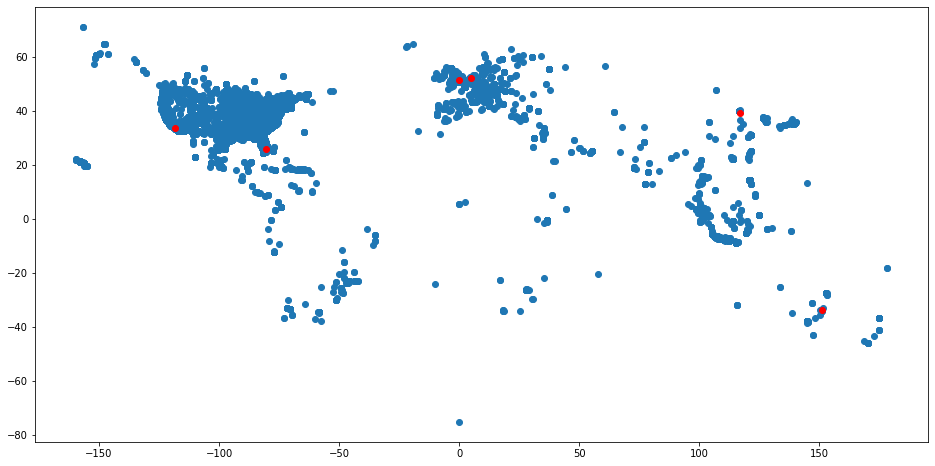

In [ ]:
plt.figure(figsize=(16,8))
plt.scatter(X_adv[:,0], X_adv[:,1])
plt.scatter(offices[:,0], offices[:,1], color='red')

Видно, что больше всего чекинов приходится на США и Европу. Скорее всего, в этих местах как раз и концетрируются основные клиенты круизного агенства. Будем держать эту особенность данных в голове и осозновать, что скорее всего, оптимальные точки для рекламных щитов будут именно в этих регионах.

Пришло время разбивать чекины на однородные группы. Будем делать это с помощью разных алгоритмов кластеризации. При подсчете расстояний будем пренебрегать тем, что Земля круглая, так как в точках, расположенных близко друг к другу погрешность мала, а в остальных точках значение достаточно велико, чтобы не повлиять на кластеризацию или сортировку.

# 1. K-средних

Напомним что сам алгоритм можно схематически представить в виде следующих шагов:

1. Инициализируем центры кластеров случайно (должно быть задано количество кластеров).
2. Относим точки к соответствующим кластерам (с минимальным расстоянием до их центра).
3. Производится пересчет центров кластеров по формуле центра масс всех точек принадлежащих кластеру.
4. Пункты 2-3 повторяются до тех пор пока центры кластеров перестанут меняться (сильно).

Посмотрим на то, как работает этот алгоритм на игрушечных данных. 

In [ ]:
from sklearn.cluster import KMeans

np.random.seed(123)
X1 = np.random.randn(100,2)
X2 = np.random.randn(100,2) - np.array([10,1])
X3 = np.random.randn(100,2) - np.array([1,10])
X = np.vstack((X1,X2,X3))
y = np.array([1]*100 + [2]*100 + [3]*100)

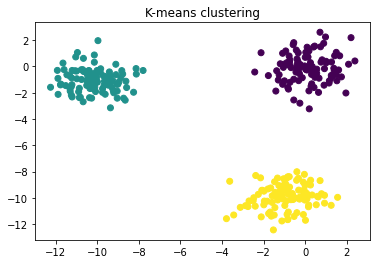

In [ ]:
k_means = KMeans(n_clusters = 3)
k_means = k_means.fit(X)
clusters = k_means.predict(X)

plt.scatter(X[:,0], X[:,1], c = clusters)
plt.title('K-means clustering');

Посмотрим что будет происходить если мы не угадали с числом кластеров.

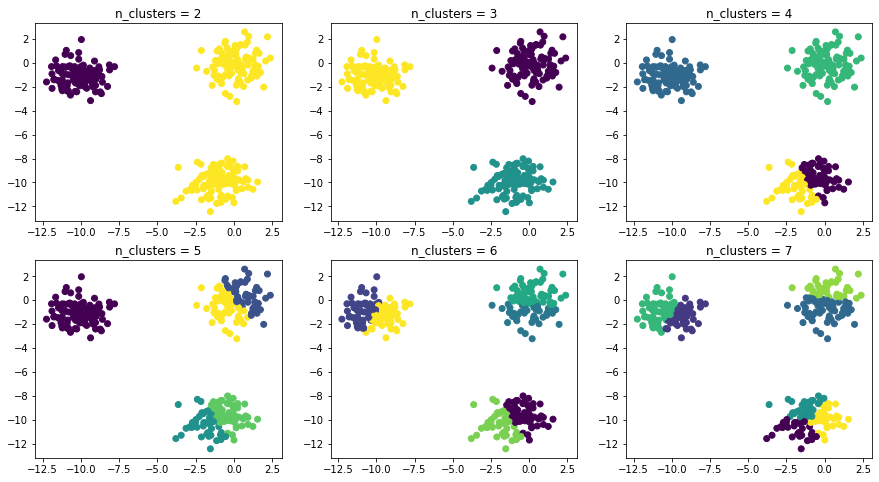

In [ ]:
plt.figure(figsize= (15,8))
for n_c in range(2,8):
    k_means = KMeans(n_clusters = n_c)
    k_means = k_means.fit(X)
    clusters = k_means.predict(X)
    plt.subplot(2,3, n_c - 1)
    plt.scatter(X[:,0], X[:,1], c = clusters)
    plt.title('n_clusters = {}'.format(n_c))

- Один из главных недостатков k-means является случайная инициализация центров кластеров, что может привести к различным результатам кластеризации.
- Главным же достоинством является скорость алгоритма. На каждой итерации требуется пересчет только расстояний до центров кластеров.
- Как мы видим k-means обязательно пытается отдать каждому кластеру какие-то объекты и, как большинство алгоритмов кластеризации зависит от заданного числа кластеров. Число кластеров в k-means можно подбирать. Но тут будут небольшие проблемы.

В отличие от задачи классификации или регресии, в случае кластеризации сложнее выбрать критерий, с помощью которого было бы просто представить задачу кластеризации как задачу оптимизации. В случае kMeans распространен вот такой критерий – сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся.

$$ 
J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,
$$

здесь $C$ – множество кластеров мощности $K$, $\mu_k$ – центроид кластера $C_k$.

__Здравый смысл в этом есть:__ мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого фнукционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента).

Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально говоря 


$$
Q(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_{k})| } \to \min_{k}
$$






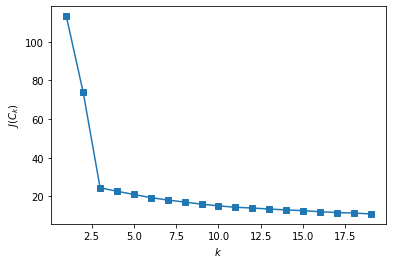

In [ ]:
from sklearn import metrics 
from scipy.spatial.distance import cdist

rg = range(1, 20)
inertia = []
for k in rg:
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))
    
plt.plot(rg, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Видно, что для нашего примера трёх кластеров достаточно. Есть огромное количество других способов выбирать количество кластеров автоматически, например можно ввести вероятностный подход к выбору числа кластеров (очень похоже на EM-алгоритм с автоматическим выбором количества компонент). 

__Вернёмся к рекламе.__ Попробуем запустить алгоритм с $50$-ю кластерами.

In [ ]:
%%time
from sklearn.cluster import KMeans
kmeanModel = KMeans(n_clusters=50)
kmeanModel.fit(X_adv)

centers = kmeanModel.cluster_centers_ 
labels = kmeanModel.labels_

CPU times: user 7.6 s, sys: 4.04 s, total: 11.6 s
Wall time: 6.04 s


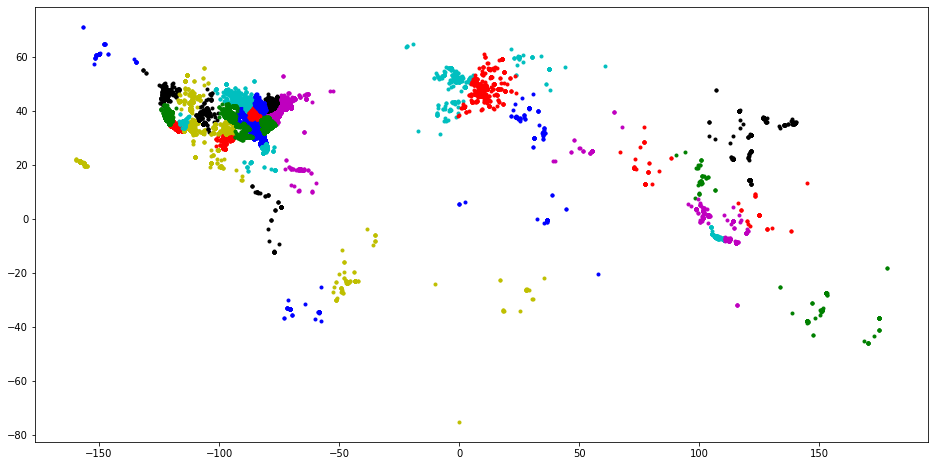

In [ ]:
from itertools import cycle

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(figsize=(16,8))

# Будем перебирать все цвета внутри вот этого цикла
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    center = centers[k]
    
    # Каждый кластер наносим на график своим цветом 
    plt.plot(X_adv[my_members,0],X_adv[my_members,1],col + '.' )

Можно попробовать подобрать оптимальное число кластеров методом, который мы рассмотрели выше. Он не даст нам ничего хорошего. Кривая будет плавно убывать при росте числа кластеров.

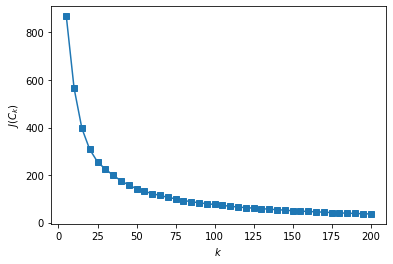

In [ ]:
rg = range(5, 205, 5)
inertia = []

X_smpl = X_adv[:10000] # чтобы побыстрее отработало

for k in rg:
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_smpl)
    inertia.append(np.sqrt(kmeans.inertia_))
    
plt.plot(rg, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Какие особенности алоритма мы видим на нашей задаче? 

- Судя по всему, кластеры выстраиваются в соотвествии с границами стран или штатов, это не очень хорошо, непонятно как можно поставить рекламный щит в середине страны. 
- Кластеры оказываются разного размера, а нам хотелось бы, чтобы для каждого банера, по площади, кластеры были одинаковыми, так как хочется одинаковой видимости, а не один банер на всю Францию с непонятно какой видимостью.

__Судя по всему, нам нужен алгоритм, который формирует кластеры в рамках какой-то заранее заданной окрестности.__

Отдельно отметим, что есть вариация k-medians, которая вместо центров кластеров вычисляет "центроиды", то есть при вычислении центров кластеров использует медиану вместо среднего. Что позволяет алгоритму стать более устойчивым к выбросам.

# 2. DBSCAN (Density-based spatial clustering of applications with noise)

Это алгоритм, основанный на плотности — если дан набор объектов в некотором пространстве, алгоритм группирует вместе объекты, которые расположены близко и помечает как выбросы объекты, которые находятся в областях с малой плотностью (ближайшие соседи которых лежат далеко). Алгоритм имеет два основных гиперпараметра:

- `eps` &mdash; радиус рассматриваемой окрестности
- `min_samples` &mdash; число соседей в окрестности

Все точки делятся на основные точки, достижимые по плотности точки и выбросы следующим образом:

- Точка $p$ является __основной точкой,__ если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем `eps` до неё. Говорят, что эти точки достижимы прямо из $p$.
- Точка $q$ __прямо достижима__ из $p$, если точка $q$ находится на расстоянии, не большем `eps` , от точки $p$ и $p$ должна быть основной точкой.
- Точка $q$ __достижима__ из $p$, если имеется путь $p_1,…,p_n$ где $p_1=p$ и $p_n=q$, а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$)
- Все точки, не достижимые из основных точек, считаются __выбросами.__
- Если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимые из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.

На диаграмме ниже `min_samples = 4`.  Точка $A$ и другие красные точки являются основными точками, поскольку область с радиусом `eps` , окружающая эти точки, содержит по меньшей мере 4 точки (включая саму точку). Поскольку все они достижимы друг из друга, точки образуют один кластер. Точки $B$ и $C$ основными не являются, но достижимы из $A$ (через другие основные точки), и также принадлежат кластеру. Точка $N$ является шумовой. 

<p><a href="https://commons.wikimedia.org/wiki/File:DBSCAN-Illustration.svg#/media/Файл:DBSCAN-Illustration.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/1200px-DBSCAN-Illustration.svg.png" alt="DBSCAN-Illustration.svg" width="450" height="450"> </a><br>Автор: <a href="//commons.wikimedia.org/wiki/User:Chire" title="User:Chire">Chire</a> &mdash; <span class="int-own-work" lang="ru">собственная работа</span>, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>

Посмотрим на результаты кластеризации при разном выборе параметра `eps` и `min_samples` на нашем игрушечном примере. 

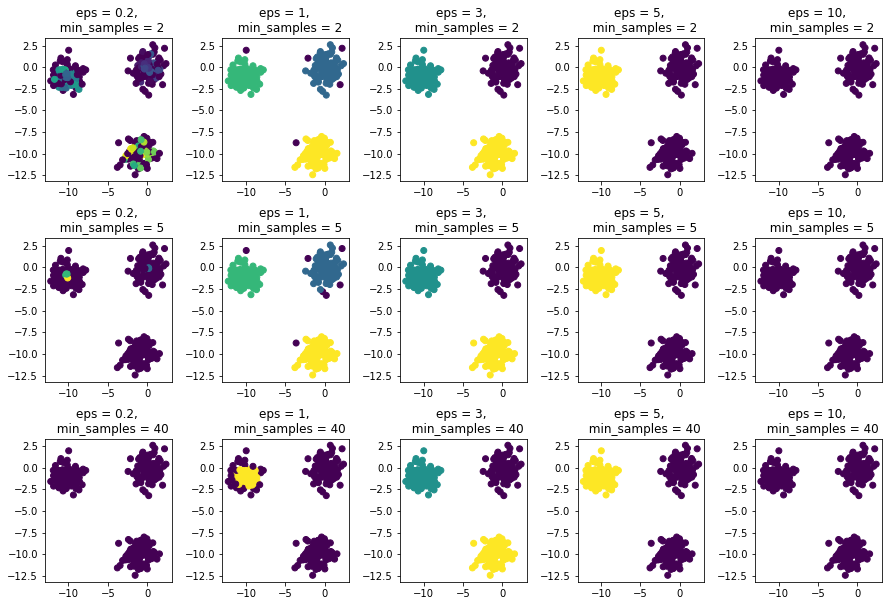

In [ ]:
from sklearn.cluster import DBSCAN

smpl = [2, 5, 40]
eps = [0.2, 1, 3, 5, 10]

fig, axs = plt.subplots(len(smpl), len(eps), figsize=(15, 10))
fig.subplots_adjust(hspace = 0.4, wspace=0.4)

for i,samples in enumerate(smpl):
    for j,e in enumerate(eps):
        dbscan = DBSCAN(eps=e, min_samples=samples)
        clusters = dbscan.fit_predict(X)
        
        axs[i, j].scatter(X[:,0], X[:,1], c = clusters)
        axs[i, j].set_title('eps = {}, \n  min_samples = {}'.format(e, samples))

Метод умеет хорошо искать кластеры сложной формы. При этом он ддовольно сложный в настройке – очень чувствителен к параметру ”плотности” `eps`. Давайте попробуем поперибирать значение `eps` и посмотрим как меняется число кластеров и шумовых наблюдений. 

In [ ]:
# для начала считаем все наблюдения аномальными
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []

# берем маленький эпсилон и начинаем увеличивать
eps = 0.05
eps_history = [eps]

while outlier_percentage > 0.1:    
    model = DBSCAN(eps=eps).fit(X)
    
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])
    
    # считаем текущий процент "шума"
    outlier_percentage = sum(labels==1) / len(labels)    
    eps += 0.05
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)

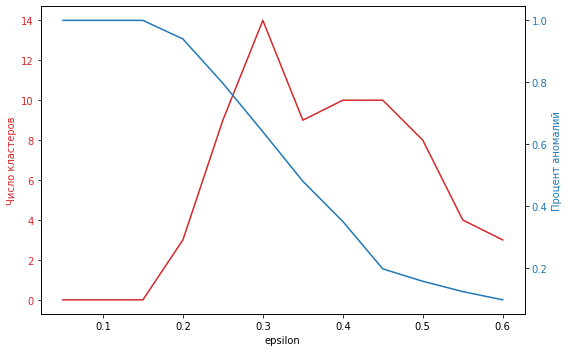

In [ ]:
iterations = eps_history[:-1]

fig, ax1 = plt.subplots(figsize=(8,5))
color = 'tab:red'
ax1.set_xlabel('epsilon')
ax1.set_ylabel('Число кластеров', color=color)
ax1.plot(iterations, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # инициализация второй оси в соотвествии с размером первой

color = 'tab:blue'
ax2.set_ylabel('Процент аномалий', color=color)
ax2.plot(iterations, anomaly_percentage, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

__Вернёмся к рекламе.__ 

DBSCAN понимает где какая плотность точек. Попробуем запустить его на наших данных. Подумаем о том, какие параметры выбрать. 

- $0.1$ градус это примерно $5-10$ км в средних широтах
- Параметр `eps` отвечает за максимальную дистанцию между двумя точками в рамках одного кластера. Было бы неплохо, если бы внутри кластера точки находились не очень далеко друг от друга, это позволит выделить наиболее плотные сгустки. Если поставим $0.01$, то мы разрешим расстояние между точками $500$ метров - $1$ км в средних широтах. Наверное, можно отнести такие чекины к одному туристическому объекту.
- Параметр `min_samples`, минимальное число чекинов в кластере, давайте возьмём $10$, чтобы избавиться от маргинальных кластеров по 1-2-3 наблюдения. 

In [ ]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.01, min_samples=10).fit(X_adv)

labels = clustering.labels_

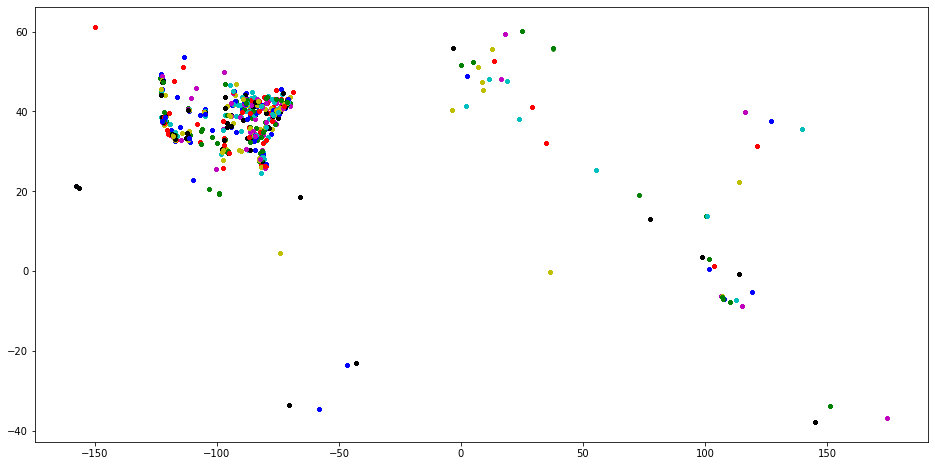

In [ ]:
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(figsize=(16,8))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    plt.plot(X_adv[my_members,0],X_adv[my_members,1],col + '.' )

In [ ]:
n_clusters_

1093

Меткой $-1$ отмечаются шумовые точки, их получается около $15\%$. 

In [ ]:
np.sum(labels == -1) # меткой -1 отмечаются шумовые точки

15308

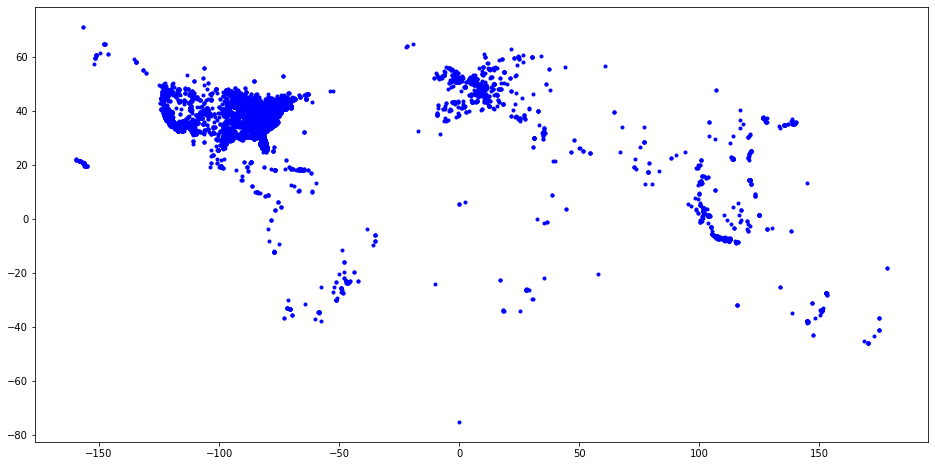

In [ ]:
my_members = labels == -1

plt.figure(figsize=(16,8))
plt.plot(X_adv[my_members,0],X_adv[my_members,1],col + '.' )

Помотрим на размеры других кластеров.

In [ ]:
from collections import Counter
cnt = Counter(labels)
cnt.most_common()[:20]

[(-1, 15308),
 (17, 6145),
 (15, 4943),
 (28, 3831),
 (50, 2764),
 (5, 2108),
 (61, 1905),
 (2, 1502),
 (62, 1487),
 (24, 1200),
 (53, 1162),
 (83, 1142),
 (25, 1139),
 (23, 1122),
 (136, 1083),
 (34, 1074),
 (0, 1046),
 (44, 1000),
 (66, 988),
 (10, 939)]

- Из-за логичного подбора параметров кластеры получилсь довольно компактными, а не размером в страну.
- Кластеры очень разные по размерам.
- Кластеры могут быть причудливой формы. Например, вытянутыми, как бананы. Из-за этого сложно понять где у него центр и куда пихать щит, в отличие от выпуклых кластеров в k-means.

Для решения нашей задачи DBSCAN не очень подходит. 

# 3. Иерархическая кластеризация

Посмотрим на ещё один алгоритм. Существует два варианта иерархической кластеризации:

- агломеративная, в которой алгоритм на каждой итерации объединяет два меньших кластера в один;
- дивизивная, в которой алгоритм на каждой итерации разбивает один кластер на два более мелких.

Мы рассмотрим агломеративный подход к кластеризации: 

1. Инициализируем наше множество кластеров, каждая точка считается своим кластером. То есть для выборки размера $N$ у нас на первой итерации будет $N$ кластеров. Также входным параметром алгоритму подается метрика расстояния между двумя кластерами. Самой популярной метрикой является расстояние Уорда.
2. На каждой итерации  мы объединяем два кластера в один. Объединяющиеся кластера выбираются в соответствии с наименьшим расстоянием Уорда. То есть в соответствии с выбранным нами расстоянием эти два кластера будут наиболее похожи и поэтому объединяются
3. Предыдущий шаг повторяется вплоть до объединения всех точек один кластер.

В результате в данном подходе мы можем выбрать любое количество кластеров после завершения процедуры, просто остановив на нужном нам шаге. К тому же данный алгоритм гораздо менее чувствителен к выбору метрики между точками, тогда как другие алгоритмы сильно зависят от этого.

Для визуализации иерархической кластеризации удобно строить дендрограммы, в которых разница между уровнями равна выбранному расстоянию объединяющихся на данном этапе кластеров.

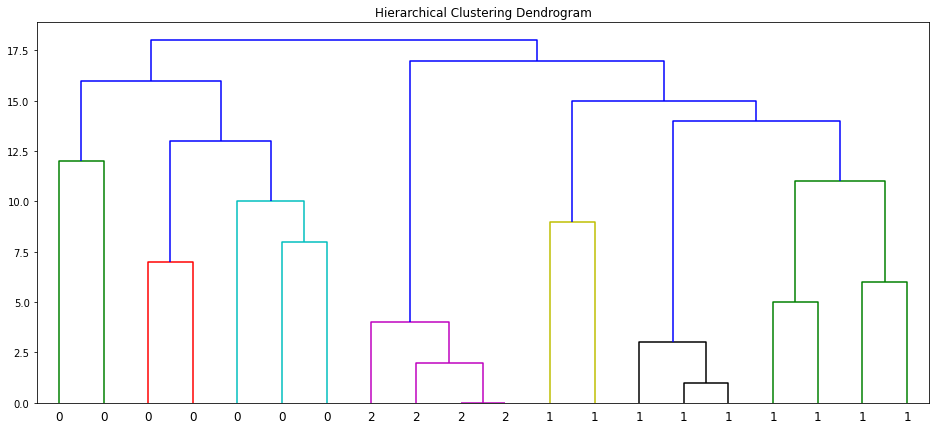

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data[:20]
model = AgglomerativeClustering(n_clusters=3)

model = model.fit(X)
plt.figure(figsize=(16,7))
plot_dendrogram(model, labels=model.labels_)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

Если нет каких-то специализированных условий (например известно что кластеров должно быть не более $K$), то число кластеров можно выбирать по резкому скачку дендрограммы. *Кроме того в некоторых задачах важно понимать для чего делается кластеризация и доменную область задачи, исходя из этого можно сильно сократить искомое количество кластеров*.  

Также в иерархическую кластеризацию можно передавать дополнительную (например априорную) информацию вида I-я и J-я точки "похожи". Это задается через матрицу связей.

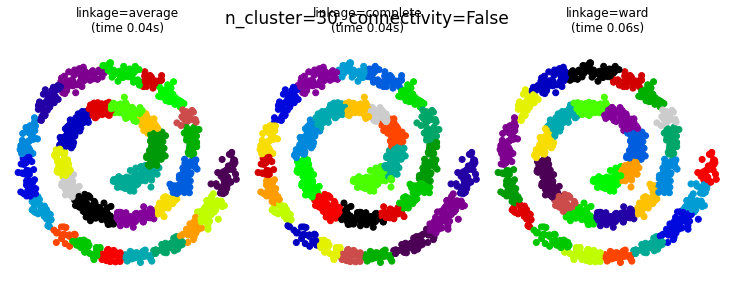

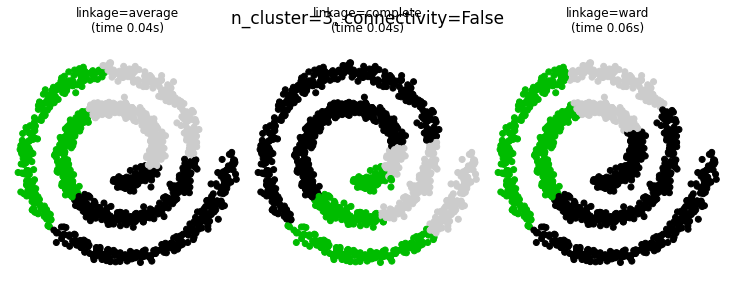

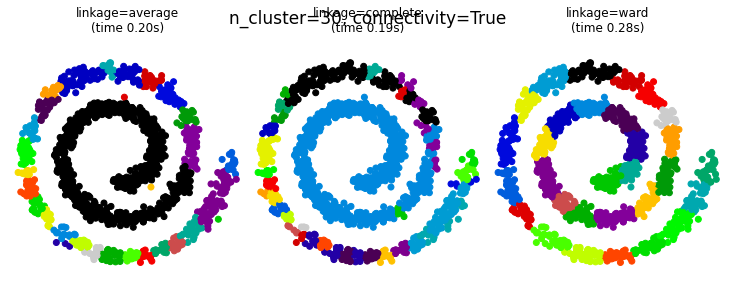

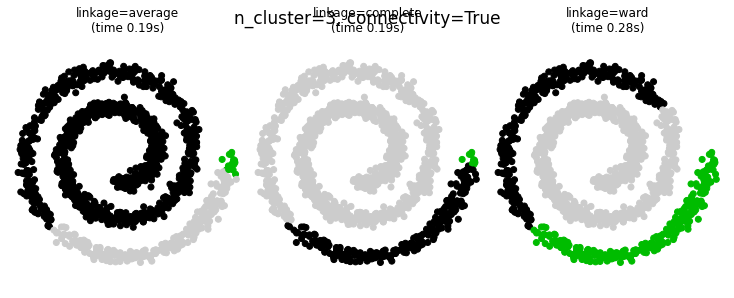

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)

X = np.concatenate((x, y))
X += .7 * np.random.randn(2, n_samples)
X = X.T

# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 30, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in (30, 3):
        fig = plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average',
                                         'complete',
                                         'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_,
                        cmap=plt.cm.nipy_spectral)
            plt.title('linkage=%s\n(time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')
            
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)
            
            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)

plt.show()

__Вернёмся к рекламе.__ 

Даже пробовать не будем для рекламы этот алгоритм. Он будет работать довольно долго из-за того, что нам придется посчитать все взаимные расстояния между точками. Сам по себе алгоритм не устранит проблемы, которые возникли выше. 

# 4. Сравнение работы алгоритмов

Сгенерируем кластеры разной формы и посмотрим на результаты работы алгоритмов

Automatically created module for IPython interactive environment


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:551: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  X, connectivity, affinity=affinity
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:551: UserWarning: the number of connected components of the connectivity matrix is 78 > 1. Completing it to avoid stopping the tree early.
  X, connectivity, affinity=affinity
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:551: UserWarning: the number of connected components of the connectivity matrix is 51 > 1. Completing it to avoid stopping the tree early.
  X, connectivity, affinity=affinity
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:551: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  X, connectivity, affinity=affinity


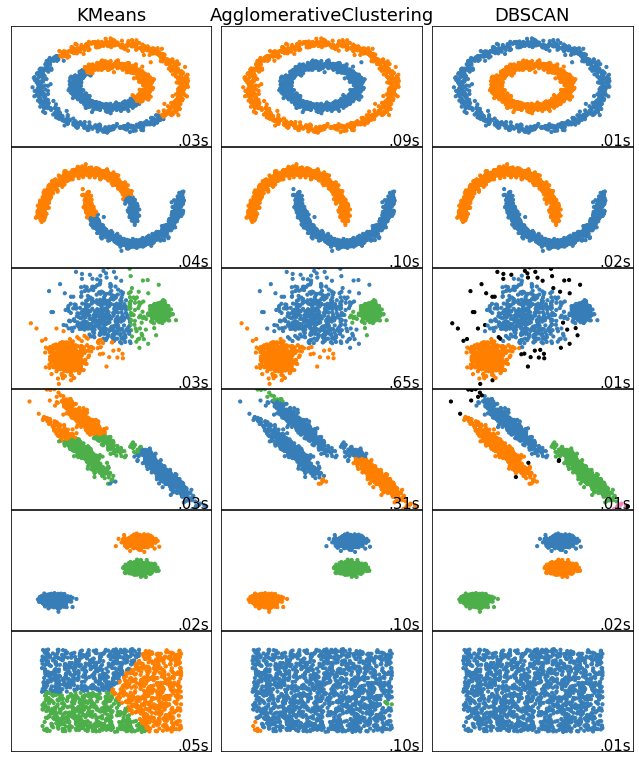

In [ ]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(3 * 2 + 3, 10.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    
    k_means = cluster.KMeans(n_clusters=params['n_clusters'])


    dbscan = cluster.DBSCAN(eps=params['eps'])
    
    average_linkage =  cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    

    clustering_algorithms = (
        ('KMeans', k_means),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

# 5. Что же делать с рекламой? 

Нам очень хотелось понять, куда можно поставит рекламный баннер. Мы рассмотрели три алгоритма. У каждого из них обнаружились свои недостатки: 

- Kmeans: непонятно как подобрать число кластеров, кластеры получаются очень разных размеров
- DBSCAN: кластеры оказываются плотными, но очень причудливой формы и разных размеров
- Агломеративная кластеризация: долго работает, кластеры разных размеров

Глобальная проблема заключалась в том, что ни один из алгоритмов не мог ограничить расстояние от центра кластера до самой крайней точки. К счастью, алгоритмов кластеризации довольно много.

Для решения найшей задачи подойдет алгоритм `MeanShift`. Его описание можно посмотреть в [sklearn user guide.](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)  В этом алгоритме можно искусственно ограничить радиус, в котором мы ищем центроиду каждого кластера с помощью специальной опции `bandwidth`. Укажем `bandwidth=0.01`, что в переводе из градусов в метры колеблется примерно от 500 метров до 1 км в средних широтах.

- Параметр `bin_seeding` делает более умную инициализацию начальных координат. Если он установлен в True, алгоритм пытается инициализировать исходные точки в тех местах, где сосредоточено много данных.
- Параметр `min_bin_freq` отвечает за минимальное число точек в кластере

In [ ]:
%%time
from sklearn import cluster
clt = cluster.MeanShift(bandwidth=0.01, bin_seeding=True, min_bin_freq=20)
clt.fit(X_adv)

CPU times: user 2.2 s, sys: 28.9 ms, total: 2.23 s
Wall time: 2.24 s


In [ ]:
labels = clt.labels_         
centers = clt.cluster_centers_ 

n_clusters_ = len(centers)
n_clusters_

557

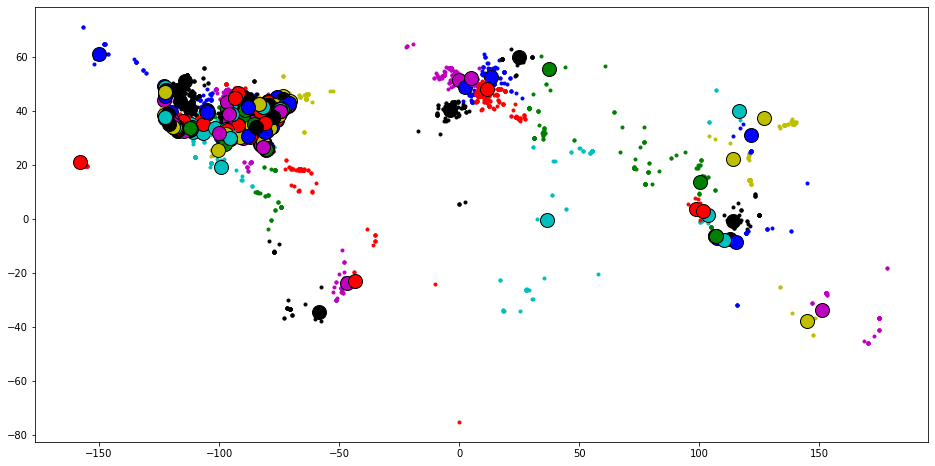

In [ ]:
plt.figure(figsize=(16,8))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    center = centers[k]
    
    # Каждый кластер наносим на график своим цветом 
    plt.plot(X_adv[my_members,0],X_adv[my_members,1],col + '.' )
    
    # Выделяем у кластеров центры 
    plt.plot(center[0], center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)

Мы должны выбрать 20 самых близких к офисам точек. Для этого отсортируем центры кластеров по расстояниям до каждого офиса. 

In [ ]:
results = [ ]
for item in offices:
    for jtem in centers:
        cur_rast = float(np.linalg.norm(jtem - item, ord=2))
        trio = (cur_rast, jtem, item)
        results.append(trio)

In [ ]:
# всего у нас есть вот столько вариантов расположить рекламные щиты
len(results)

3342

In [ ]:
results.sort()         # отсортировали по расстоянию
best_20 = results[:20] # взяли 20 самых близких
best_20[:5]

[(0.009535493917399059,
  array([ 4.89244879, 52.37283715]),
  array([ 4.885084, 52.378894])),
 (0.010277170788663512,
  array([151.21085173, -33.85991722]),
  array([151.205134, -33.868457])),
 (0.047114342000942666,
  array([-80.2781057,  25.8575963]),
  array([-80.324116,  25.867736])),
 (0.050904818658285604,
  array([-0.12632396, 51.50054819]),
  array([-0.075479, 51.503016])),
 (0.05741906793566585,
  array([-80.3553302,  25.8195424]),
  array([-80.324116,  25.867736]))]

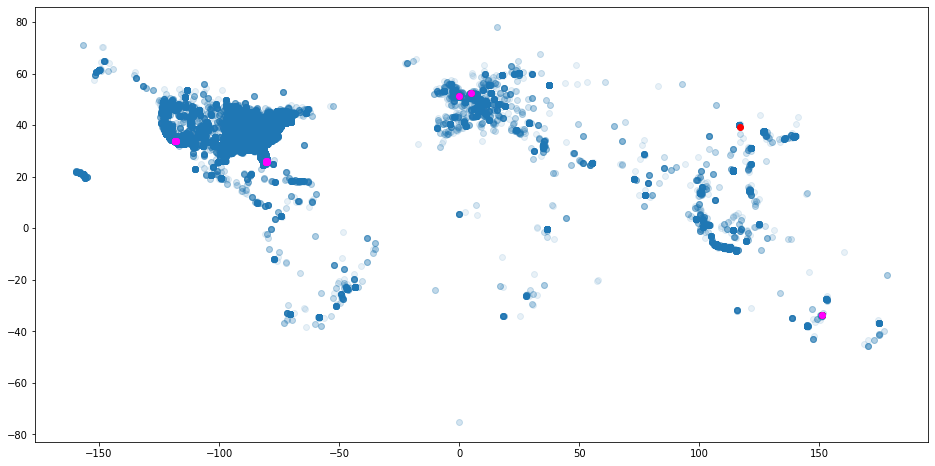

In [ ]:
# Распакуем координаты для строительства картинки 
coord = np.array([[item[1][0],item[1][1]] for item in best_20])

plt.figure(figsize=(16,8))
plt.scatter(df.longitude.values, df.latitude.values, alpha=0.1)  # Наносим все чекины
plt.scatter(offices[:,0], offices[:,1], color='red')             # Наносим офисы 
plt.scatter(coord[:,0], coord[:,1], color='magenta')             # Наносим точки для рекламы 

Посмотрим в окрестностях какого офиса оказалась большая часть баннеров.

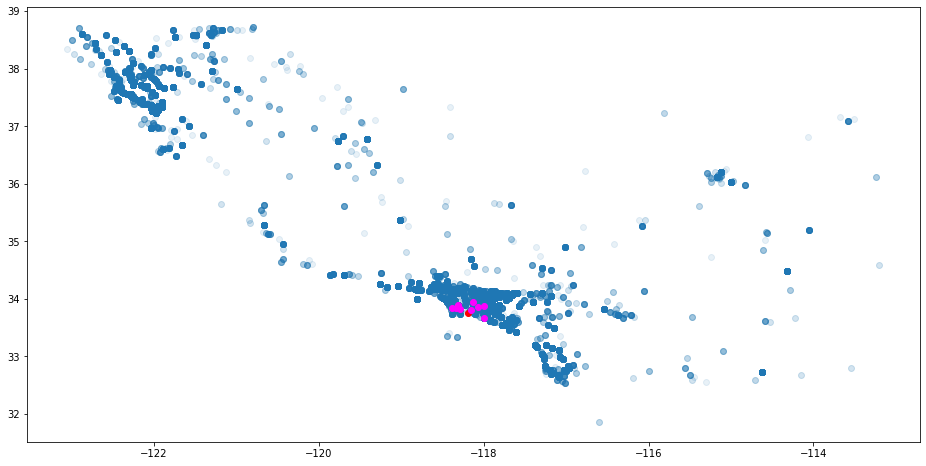

In [ ]:
l = 5
с_long = offices[0][0]
c_lat = offices[0][1]

X_int = df[(df.longitude > с_long - l)&(df.longitude < с_long + l)& 
          (df.latitude >  - l)&(df.latitude < c_lat + l)]
    
coord_int = coord[(coord[:,0] > с_long - l)&(coord[:,0] < с_long + l)& 
                  (coord[:,1] > c_lat - l)&(coord[:,1] < c_lat + l)]    

offices_int = offices[(offices[:,0] > с_long - l)&(offices[:,0] < с_long + l)& 
                    (offices[:,1] > c_lat - l)&(offices[:,1] < c_lat + l)] 

plt.figure(figsize=(16,8))
plt.scatter(X_int.longitude.values,X_int.latitude.values, alpha=0.1)  # Наносим все чекины
plt.scatter(offices_int[:,0], offices_int[:,1], color='red')          # Наносим офисы 
plt.scatter(coord_int[:,0], coord_int[:,1], color='magenta')          # Наносим точки для рекламы 

Это Калифорния.

Итак, мы только что помогли выбрать круизному агенству просматриваемые и близкие к офисам точки для рекламы. В ходе решения задачи: 

- Мы выслушали заказчика и поняли какие есть ограничения.
- Мы придумали откуда взять данные и как по ним найти популярные места. 
- Мы нашли подходящий алгоритм кластеризации и обучили модель.
- Мы подыскали самые просматриваемые локации в окрестности офисов. 

Осталось только нарисовать красивую презентацию и показать это добро "Carnival Cruise Line". 

## Материалы

- [Обзор](https://scikit-learn.org/stable/modules/clustering.html) разных алгоритмов кластеризации из sklearn
- Визуализация работы [K-Means](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)
- Визуализация работы [DBSCAN](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)
- [Подробнее про разные метрики кластеризации](http://nlp.uned.es/docs/amigo2007a.pdf ) и критерии для них
- [Про рразные методы кластеризации](http://www.datalaundering.com/download/mm2.pdf)
